In [1]:
%pylab inline
import h5py
import fitsio
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import hist
from astropy import coordinates as coords
from scipy import stats
import networkx as nx

import gwb

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(style.available)

['seaborn-poster', 'seaborn-colorblind', 'seaborn-deep', 'seaborn-dark-palette', 'seaborn-muted', 'seaborn-darkgrid', 'seaborn-bright', 'seaborn-ticks', 'seaborn-talk', 'fivethirtyeight', 'grayscale', 'ggplot', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-dark', 'seaborn-white', 'classic', 'dark_background', 'bmh', 'seaborn-whitegrid']


In [3]:
style.use(['seaborn-colorblind', 'notebook.mplstyle'])

# Load Data

In [4]:
tgas = gwb.TGASData('../data/stacked_tgas.fits')

In [5]:
pairidx_rand = fits.getdata('../output/random/snr8_random200000.fits')
with h5py.File("../output/random/snr8_random200000_vscatter0-lratio.h5") as f:
    lnH1_rand = f['lnH1'].value
    lnH2_rand = f['lnH2'].value
    llr_rand = lnH1_rand - lnH2_rand
# throw out nans
bad = isnan(llr_rand)
pairidx_rand = pairidx_rand[~bad]
lnH1_rand = lnH1_rand[~bad]
lnH2_rand = lnH2_rand[~bad]
llr_rand = llr_rand[~bad]

# pairidx_rand_sn32 = fits.getdata('../output/random/snr32_random100000.fits')
# with h5py.File("../output/random/snr32_random100000_vscatter0-lratio.h5") as f:
#     lnH1_rand_sn32 = f['lnH1'].value
#     lnH2_rand_sn32 = f['lnH2'].value
#     llr_rand_sn32 = lnH1_rand_sn32 - lnH2_rand_sn32
# # throw out nans
# bad = isnan(llr_rand_sn32)
# pairidx_rand_sn32 = pairidx_rand_sn32[~bad]
# lnH1_rand_sn32 = lnH1_rand_sn32[~bad]
# lnH2_rand_sn32 = lnH2_rand_sn32[~bad]
# llr_rand_sn32 = llr_rand_sn32[~bad]

# pairidx = fits.getdata('../output/21081/snr8_n128_dv10_new.fits')
# with h5py.File("../output/21081/snr8_n128_dv10_vscatter0-lratio.h5") as f:
#     lnH1 = f['lnH1'].value
#     lnH2 = f['lnH2'].value
#     llr = lnH1 - lnH2
pairidx = fits.getdata('../output/23560/snr8_r10_dv10.fits')
with h5py.File("../output/23560/snr8_r10_dv10_vscatter0-lratio.h5") as f:
    lnH1 = f['lnH1'].value
    lnH2 = f['lnH2'].value
    llr = lnH1 - lnH2

In [36]:
parallax_snr = tgas.parallax_snr
vtan = tgas.get_vtan().value
c = tgas.get_coord()
d = tgas.get_distance().value

star1, star2 = pairidx['star1'], pairidx['star2']
min_snr = np.min(np.vstack((parallax_snr[star1], parallax_snr[star2])), axis=0)
dvtan = norm(vtan[star1]-vtan[star2], axis=1)
vtanmean = (vtan[star1] + vtan[star2])*0.5
sep = c[star1].separation_3d(c[star2]).value
sep_sky = c[star1].separation(c[star2])

c1 = c[star1]
c2 = c[star2]
ra1, dec1 = c1.ra.value, c1.dec.value
ra2, dec2 = c2.ra.value, c2.dec.value
l1, b1 = c1.transform_to(coords.Galactic).l.value, c1.transform_to(coords.Galactic).b.value
l2, b2 = c2.transform_to(coords.Galactic).l.value, c2.transform_to(coords.Galactic).b.value
d1 = d[star1]
d2 = d[star2]
dmean = (d1+d2)*0.5

/Users/semyeong/projects/gaia-wide-binaries/gwb/data.py:102: RuntimeWarning: invalid value encountered in sqrt
  tmp = self._data['parallax'] * (0.5 + 0.5*np.sqrt(1 - 16/snr**2))


In [7]:
pairidx.size

271232

# Figure: Likelihood ratio histogram

In [60]:
rc('text', usetex=True)
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica Neue']})

In [ ]:
# import corner

# corner.hist2d(log10(pairidx['sep']), pairidx['delta_v'],
#               data_kwargs={"alpha":.3})
axes([0.2,0.18,0.75,0.77])
plot(pairidx['sep'], pairidx['delta_v'], 'k.', alpha=0.3, ms=3, rasterized=True)
xlabel(r'separation $|\Delta \boldsymbol{x}|$ [pc]', size=20)
yl = ylabel(r'$|\Delta \boldsymbol{v}_{\rm{t}}|$ [km s$^{-1}$]')
figtext(0.05, 0.55, "tangential velocity difference", ha='center', va='center',
        rotation='vertical', size=20)

from astropy.constants import G
tmpsep = logspace(-3,1)
v = sqrt(G*(2*u.solMass)/(tmpsep*u.pc)).to(u.km/u.s).value
plot(tmpsep, v, label=r"$v_\mathrm{orb} (a)$"
     "\n"
     r"(assuming $M=2\,M_\odot$)")
legend(loc='upper left', fontsize=15, frameon=False)

xscale('log')
_ = yticks([0,2,4,6,8,10])

savefig('../paper/figures/sep_dvtan.pdf', dpi=150)

In [ ]:
fig, ax = subplots(1, 2, figsize=(10,4))
fig.subplots_adjust(left=0.1, right=0.98, bottom=0.2, top=0.95, wspace=.2)
sca(ax[0])
hist(llr, bins=np.linspace(-50,12,256), color='k', histtype='step',
        normed=True, label='entire candidate pairs', lw=2)
# slices in dvtan
for cut, color in zip([0.5, 5, 9.5], ['#253494','#2c7fb8','#41b6c4']):
    cond_dvtan_strip = fabs(dvtan-cut)<0.5
    print('dvtan', cut, cond_dvtan_strip.sum())
    hist(llr[cond_dvtan_strip], lw=1.5,
         bins=np.linspace(-15,12,64), color=color,
         normed=True, histtype='step',
         label=r'|$\Delta v_t -$%.1f| < 0.5' % (cut), )
# random pairs of stars
_ = hist(llr_rand, bins=linspace(-15,12,64),
         color='0.8', normed=True, zorder=-1,
         label='random pairs')

legend(loc='upper left', frameon=False)
xlim(-5,10)
xlabel(r'$\ln (L_1/L_2)$')
ylabel('density')
tick_params(axis='both', length=8, width=1.)

sca(ax[1])
# slices in ln(L1/L2)
# for cut, color, ms in zip([2, 5, 6.5], ['#969696', '#636363', '#252525'], [4, 2, .5]):
for cut, color, ms in zip([2, 5, 6.5], ['0.7', '0.4', '0.'], [4, 2, .5]):
    cond_lr_slice = fabs(llr-cut)<0.25
    print('ln(L1/L2)', cut, cond_lr_slice.sum())
    plot(log10(pairidx['sep'][cond_lr_slice]), pairidx['delta_v'][cond_lr_slice],
         c=color, marker='o', ls='None', ms=2, alpha=.5,
         label='|$\ln (L_1/L_2)-$%.1f|<0.25' % (cut))
xlabel('log separation [pc]',)
ylabel('$|\Delta v_t|$ [km s$^{-1}$]', labelpad=-5)
xticks([-2,-1,0,1])
leg = legend(loc='upper left', numpoints=1, markerscale=3, frameon=False)

# savefig('../paper/figures/likelihoodratios.pdf')

In [ ]:
sum(pairidx['sep']<1), sum((sep<1) & (llr>6))

In [ ]:
_ = hist(llr, bins=linspace(2,13,128),cumulative=-1, log=True, histtype='step')
_ = hist(llr[sep<1], bins=linspace(2,13,128),cumulative=-1, log=True)
_ = hist(llr[sep>1], bins=linspace(2,13,128),cumulative=-1, log=True, histtype='step')
gca().invert_xaxis()
ylabel('cumulative number of pairs', size=15)
xlabel('$\ln (L_1/L_2)$')

figure()
_=hist(llr[sep<1], linspace(-50,50,128))
xlim(-5,15)
grid()

In [ ]:
cond_lr_cut = llr>6
print(cond_lr_cut.sum(), sum((sep<1)&cond_lr_cut))
cmpairs = pairidx[cond_lr_cut]

In [ ]:
sum(llr_rand>6)/llr_rand.size, sum((llr_rand>6) & (pairidx_rand['delta_v']<10))/(pairidx_rand['delta_v']<10).sum()

# Examine the network of pairs

In [ ]:
graph = nx.from_edgelist(
    [(i,j) for i,j in zip(cmpairs['star1'],cmpairs['star2'])])

In [ ]:
connected = array([array(list(c)) for c in nx.connected_components(graph)])
sizes = array([len(c) for c in nx.connected_components(graph)])
print('number of nodes %i' % (len(graph)))
print('total number of connected components %i' % (connected.size))
print(min(sizes),max(sizes))

In [ ]:
nn_nodes = array([len(graph.neighbors(i)) for i in graph.nodes()])
print('most connected star ind %i connection size %i' % (graph.nodes()[nn_nodes.argmax()], nn_nodes.max()))
print(tgas[graph.nodes()[nn_nodes.argmax()]]._data)

In [ ]:
plt.hist?

In [ ]:
counts,_,_ = hist(sizes, bins=arange(1.5,10.6,1), log=True,
                  histtype='bar', color='k', facecolor='None', edgecolor='k')
print(counts.sum())
xlim(1.5, 11.5)
xticks([2,3,4,5,6,7,8,9,10,11])
xlabel('size of connected component')
ylabel('count')
text(0.95, 0.95, '%i with size $>$ 10 not shown' % ((sizes>10).sum()),
     transform=gca().transAxes, va='top', ha='right', size=15)
tight_layout()
savefig('../paper/figures/dist_networksize.pdf')

In [ ]:
# sorted list of subgraphs from largest to smallest
Gc = array(sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True))
sizes = array([len(g) for g in Gc])

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec

def set_line_alpha(ax):
    linecollection = ax.collections[1]
    linecollection.set_alpha(0.5)

fig = figure(figsize=(10,4))
fig.subplots_adjust(top=0.95, right=0.98, bottom=0.17, left=0.08)
ax0 = subplot(121)
g = Gc[0]
# pos = {node:(tgas.l[node], d[node]) for node in g.nodes()}
pos = {node:(tgas.ra.value[node], tgas.dec.value[node]) for node in g.nodes()}
nx.draw_networkx(g, pos=pos, node_size=10, width=.5, with_labels=False, alpha=1)
set_line_alpha(ax0)
xlabel(r'$\alpha$ [deg]')
ylabel(r'$\delta$ [deg]')
text(0.05, 0.05, 'size=%i\n%i edges' % (len(g), len(g.edges())),
     transform=gca().transAxes, va='bottom', ha='left', size=20)

grid = gridspec.GridSpec(2,2)
grid.update(left=0.54, right=0.98, wspace=0.25)
ax = [subplot(i) for i in grid]
for i, gi in enumerate([6,13,37,51]):
    g = Gc[gi]
#     pos = {node:(tgas.l[node], d[node]) for node in g.nodes()}
    pos = {node:(tgas.ra.value[node], tgas.dec.value[node]) for node in g.nodes()}
    nx.draw_networkx(g, pos=pos, node_size=10, width=.5, with_labels=False, ax=ax[i])
    ax[i].xaxis.set_major_locator(MaxNLocator(nbins=5,prune='both'))
    ax[i].yaxis.set_major_locator(MaxNLocator(nbins=5,prune='both'))
    ax[i].text(0.95, 0.05, 'size=%i\n%i edges' % (len(g), len(g.edges())),
               transform=ax[i].transAxes, va='bottom', ha='right', size=15)
    ax[i].tick_params(which='both', labelsize=15)
    set_line_alpha(ax[i])
savefig('../paper/figures/graphviz_examples.pdf')

In [ ]:
a = array(Gc[6].nodes())
plot(tgas.l[a], tgas.get_distance()[a], '.')
plot(mwsc['GLON'], mwsc['d'], 'ro')
for cl in mwsc[
    (mwsc['d']<d[a].max()) & (mwsc['d']>d[a].min()) & (mwsc['GLON']>tgas.l[a].min()) & (mwsc['GLON']<tgas.l[a].max())]:
    text(cl['GLON'], cl['d'], cl['Name'].replace('_', ' '))
xlim(tgas.l[a].min()*0.9, tgas.l[a].max()*1.1)
ylim(d[a].min()*0.9, d[a].max()*1.1)

In [ ]:
mwsc = Table.read('../data/J_A+A_585_A101/catalog.dat', readme='../data/J_A+A_585_A101/ReadMe',
                 format='ascii.cds')
print('total number of mwsc', len(mwsc))
print('number of mwsc d<600 pc', (mwsc['d']<600).sum())

In [ ]:
obass = Table.read('../data/J_AJ_117_354/tablec1.dat', readme='../data/J_AJ_117_354/ReadMe',
                    format='ascii.cds')
print('OB association stars', len(obass))

from astroquery.simbad import Simbad

# query simbad on HIP id's to get coordinates
customSimbad = Simbad()
customSimbad.add_votable_fields('sptype', 'parallax')
result = customSimbad.query_objects(['HIP %i' % hip for hip in obass['HIP']])
print( unique([s.decode("utf-8")[0] if len(s)>0 else '?' for s in result['SP_TYPE']]) )

def get_distance(parallax, parallax_error):
    """
    Return the distance [kpc] point estimate with the Lutz-Kelker correction
    
    parallax : float, in mas
    parallax_error : float, in mas
    """
    snr = parallax / parallax_error
    pnew = parallax * (0.5 + 0.5*np.sqrt(1 - 16./snr**2))
    # if snr<4, the value will be maksed
    return 1./pnew

obass_dist = get_distance(result['PLX_VALUE'], result['PLX_ERROR'])
obass_c = coords.SkyCoord(result['RA'], result['DEC'], unit=(u.hourangle, u.deg),
                          distance=obass_dist*u.kpc)
obass_cg = obass_c.transform_to(coords.Galactic)

In [ ]:
figure(figsize=(10,5))

pairs = array([list(g.nodes()) for g in Gc[sizes==2]])
x = hstack([tgas.l[pairs], array([None]*pairs.shape[0])[:,None]])
y = hstack([d[pairs], array([None]*pairs.shape[0])[:,None]])
# manipulate GLON
x[:,:-1].sort(axis=1)
x[:,1][x[:,1]-x[:,0]>180] -= 360.
plot(x.ravel(),y.ravel(), alpha=.3, c='k', label='size 2')

pairs = array([list(g.nodes()) for g in Gc[sizes==3]])
x = hstack([tgas.l[pairs], array([None]*pairs.shape[0])[:,None]])
y = hstack([d[pairs], array([None]*pairs.shape[0])[:,None]])
# manipulate GLON
x[:,:-1].sort(axis=1)
for i in range(x.shape[1]-1):
    x[:,i][x[:,i]-x[:,0]>180] -= 360.
plot(x.ravel(), y.ravel(), alpha=.7, c='b', label='size 3')

for s in Gc[sizes>=4]:
    plot(tgas.l[s], d[s], '.', c=cm.spectral(uniform()))
    
for cc, ll in mwsc['d', 'GLON'][mwsc['d']<600]:
    l, = plot(ll, cc, 'ro', ms=8, mfc='None', mec='k', mew=1,)
    
xlim(0,360)
ylim(0,500)
# leg = legend(loc='upper left')

xlabel('Galactic longtidude [deg]')
ylabel('distance [pc]')

In [ ]:
# figure(figsize=(10,5))
figure(figsize=(10,10))
ax = subplot(111, projection='polar')
pairs = array([list(g.nodes()) for g in Gc[sizes==2]])
x = hstack([deg2rad(tgas.l[pairs]), array([None]*pairs.shape[0])[:,None]])
y = hstack([d[pairs], array([None]*pairs.shape[0])[:,None]])
# manipulate GLON
x[:,:-1].sort(axis=1)
x[:,1][x[:,1]-x[:,0]>180] -= 360.
plot(x.ravel(),y.ravel(), alpha=.3, c='k', label='size 2')

pairs = array([list(g.nodes()) for g in Gc[sizes==3]])
x = hstack([deg2rad(tgas.l[pairs]), array([None]*pairs.shape[0])[:,None]])
y = hstack([d[pairs], array([None]*pairs.shape[0])[:,None]])
# manipulate GLON
x[:,:-1].sort(axis=1)
for i in range(x.shape[1]-1):
    x[:,i][x[:,i]-x[:,0]>180] -= 360.
plot(x.ravel(), y.ravel(), alpha=.7, c='b', label='size 3')


for s in Gc[sizes>=4]:
    plot(deg2rad(tgas.l[s]), d[s], '.', c=cm.spectral(uniform()))
    
for cc, ll in mwsc['d', 'GLON'][mwsc['d']<600]:
    l, = plot(deg2rad(ll), cc, 'ro', ms=8, mfc='None', mec='k', mew=1,)
    
ylim(0,250)
yticks([100,200])

tight_layout()


In [ ]:
fig = figure(figsize=(10,10))
fig.subplots_adjust(top=0.95,bottom=0.04,right=0.93,left=0.05)

ax = subplot(111, projection='polar')
for g in Gc[::]:
    if len(g) > 5:
        pos = {node:(deg2rad(tgas.l[node]), d[node]*cos(deg2rad(tgas.b[node]))) for node in g.nodes()}
        nx.draw_networkx(g, pos=pos, node_size=3, width=.5, with_labels=False,
                         edge_color=mpl.colors.rgb2hex(cm.spectral(random.uniform())),
                         node_color='k')
    else:
        pos = {node:(deg2rad(tgas.l[node]), d[node]*cos(deg2rad(tgas.b[node]))) for node in g.nodes()}
        nx.draw_networkx_edges(g, pos=pos, width=1, with_labels=False,
                               edge_color='k',alpha=.5)
        
for cc, ll, bb in mwsc['d', 'GLON', 'GLAT'][mwsc['d']<600]:
    h1, = plot(deg2rad(ll), cc*cos(deg2rad(bb)), 'ro', ms=8, mfc='None', mec='m', mew=1,)

h2, = ax.plot(obass_cg.l.to(u.rad).value, obass_dist*1000*cos(obass_cg.b.to(u.rad).value),
              c='#bebebe', marker='.', ls='None', zorder=-100)

figlegend((h1,h2), ('star cluster', 'stars in OB Associations'), 'upper right',
       numpoints=1, frameon=False, fontsize=20,handletextpad=0, markerscale=2)
ylim(0,300)
yticks([100,200,], ['100 pc', '200 pc'])
ax.set_theta_direction(-1)
ax.set_theta_zero_location('W')
ax.set_thetagrids(arange(0,360,45), frac=1.07)

savefig('../paper/figures/glon_d_pie.pdf')

In [ ]:
mwsc.sort('d')

In [ ]:
mwsc.show_in_browser()

In [ ]:
where((llr>6) & (l1>90) & (l1<120) & (abs(l1-l2)>180))

In [ ]:
pairidx[12749]

In [ ]:
print( tgas[704255] )
print( tgas[704255].get_coord().transform_to(coords.Galactic) )
print( tgas[1325999] )
print( tgas[1325999].get_coord().transform_to(coords.Galactic) )


In [ ]:
tgas[704255].get_coord().separation_3d(tgas[1325999].get_coord())

In [ ]:
tgas[704255].l, d[704255], tgas[1325999].l, d[1325999]

# RAVE Cross-match

In [ ]:
rave = Table.read('../data/tgas_rave_RV.fits')

In [ ]:
matched_rave = ~rave['row_id'].mask
print('total number of tgas+rave matches', matched_rave.sum())

hrv = rave['HRV']
ehrv = rave['eHRV'].data

# rv1 = hrv[pairidx['star1']]
# rv2 = hrv[pairidx['star2']]
# drv = rv1 - rv2
# edrv = hypot(ehrv[pairidx['star1']], ehrv[pairidx['star2']])
# matched_rave1 = matched_rave[pairidx['star1']]
# matched_rave2 = matched_rave[pairidx['star2']]
# matched_rave12 = matched_rave1 & matched_rave2

In [ ]:
star1 = cmpairs['star1']
star2 = cmpairs['star2']
nsize = array([len(nx.node_connected_component(graph, s1)) for s1 in star1])

In [ ]:
drv = hrv[star1] - hrv[star2]
edrv = hypot(ehrv[star1], ehrv[star2])
drv_edrv = drv/edrv
cmrave = matched_rave[star1] & matched_rave[star2]

In [ ]:
print('number of pairs with RAVE', prod(matched_rave[vstack([star1,star2]).T], axis=1).sum())
print('number of mutually exclusive pairs with RAVE',
      prod(matched_rave[vstack([star1,star2]).T[nsize==2]], axis=1).sum())

In [ ]:
unique(nsize[cmrave])

In [ ]:
import pandas as pd

In [ ]:
from scipy import interpolate

In [ ]:
# colors for two groups
color_size2 = '#d95f02'
color_sizelt2 = '#1b9e77'

fig, ax = subplots(2, 1, figsize=(5, 8), sharex=True)
fig.subplots_adjust(top=0.93, hspace=0.05, left=0.2, bottom=0.08, right=0.95)
suptitle('%i pairs with RAVE RV' % cmrave.sum(), size=20, x=0.55)

sca(ax[0])
errorbar(cmpairs['sep'][cmrave & (nsize==2)], drv_edrv[cmrave & (nsize==2)],
         fmt='.',color=color_size2, label='size=2 (mutually exclusive)')
errorbar(cmpairs['sep'][cmrave & (nsize>2)], drv_edrv[cmrave & (nsize>2)],
         fmt='^', mew=1, ms=4, mec=color_sizelt2, mfc='None', label='size$>$2',)
axhline(-3, color='gray')
axhline(3, color='gray')
ylim(-10,10)
xscale('log')
xlim(2e-2,15)
ylabel('$\Delta v_r/\sigma_{\Delta v_r}$')

legend(loc=(-0.03,0.75), frameon=False, numpoints=1, markerscale=2, fontsize=15, handletextpad=0)

sca(ax[1])
n=15  # each bin contains 2n+1 data points

tmpsep = pd.Series(cmpairs['sep'][cmrave & (nsize==2)].astype('<f8'))
bool3 = pd.Series((drv_edrv<3)[cmrave & (nsize==2)].astype('<f8'))
isort = tmpsep.argsort()
tmpsep_sort = tmpsep[isort]
bool3_sort = bool3[isort]
rollsep = tmpsep_sort.rolling(2*n+1, center=True)
rollbool = bool3_sort.rolling(2*n+1, center=True)
errors = vstack([
    rollsep.median() - rollsep.min(),
    rollsep.max() - rollsep.median()]).T[n:-n]

errorbar(rollsep.median()[n:-n], rollbool.mean()[n:-n],
         xerr=errors.T, fmt='.', color=color_size2)

# fit spline
# x = log10(rollsep.median()[n:-n])
# y = rollbool.mean()[n:-n]
# tck = interpolate.splrep(x, y, s=1, k=3)
# xnew = logspace(-1, 1)
# ynew = interpolate.splev(log10(xnew), tck, der=0, ext=3)
# plot(xnew, ynew, 'b.-')

tmpsep = pd.Series(cmpairs['sep'][cmrave & (nsize>2)].astype('<f8'))
bool3 = pd.Series((drv_edrv<3)[cmrave & (nsize>2)].astype('<f8'))
isort = tmpsep.argsort()
tmpsep_sort = tmpsep[isort]
bool3_sort = bool3[isort]
rollsep = tmpsep_sort.rolling(2*n+1, center=True)
rollbool = bool3_sort.rolling(2*n+1, center=True)
errors = vstack([
    rollsep.median() - rollsep.min(),
    rollsep.max() - rollsep.median()]).T[n:-n]
errorbar(rollsep.median()[n:-n], rollbool.mean()[n:-n],
         xerr=errors.T, fmt='^', mew=1, ms=4, mec=color_sizelt2, mfc='None', ecolor=color_sizelt2, capsize=0)

xscale('log')
ylim(0.,1.05)
xlim(2e-2,15)
xlabel('separation [pc]')
ylabel('$f(\Delta v_r/\sigma_{\Delta v_r} < 3)$')
savefig('../paper/figures/raverv.pdf')

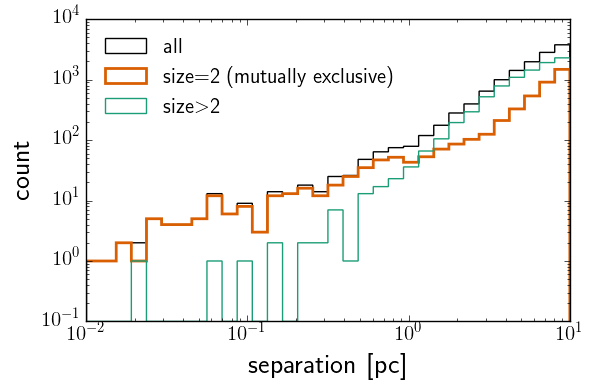

In [215]:
from astropy import stats as astats
binsize = astats.knuth_bin_width(log10(cmpairs['sep']))
bins = logspace(-2,1,3/binsize)

c,bins,patches = hist(cmpairs['sep'], bins, log=True, histtype='step',
                      label='all', color='k')
_ = hist(cmpairs['sep'][nsize==2], bins, log=True, histtype='step',
         label='size=2 (mutually exclusive)', lw=2, color=color_size2)
_ = hist(cmpairs['sep'][nsize>2], bins, log=True, histtype='step', label='size$>$2', color=color_sizelt2)
ylabel('count')
xlabel('separation [pc]')
legend(loc='upper left', fontsize=15, frameon=False)
tight_layout()
xscale('log')
savefig('../paper/figures/hist_sep.pdf')

In [ ]:

counts, edges = histogram(log10(cmpairs['sep'][nsize==2]), 32, )
centers = (edges[1:]+edges[:-1])*0.5
ynew = interpolate.splev(centers, tck, der=0, ext=3)
plot(centers, counts, 'ko-')
plot(centers, counts*ynew, 'bo-')
yscale('log')

# Color-Magnitude Diagrams

In [241]:
tmass = fits.getdata('/Users/semyeong/data/gaia/tgas_source/tgas-matched-2mass.fits')

In [242]:
gjcolor = tgas._data['phot_g_mean_mag']- tmass['j_mag']
gMag = tgas._data['phot_g_mean_mag'] + 5*(log10(tgas._data['parallax']*1e-3)+1)

In [246]:
# distance matching sample
ind_uniq = unique(hstack([cmpairs['star1'], cmpairs['star2']]))
print(ind_uniq.size)
dpairs = d[ind_uniq]

10606


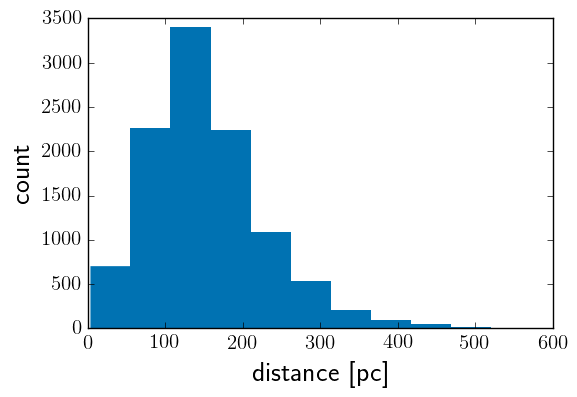

In [250]:
hist(dpairs)
xlabel('distance [pc]')
ylabel('count')

In [257]:
from sklearn.neighbors import KDTree

In [320]:
cond = (parallax_snr>8) & tmass['matched']
d_snr = d[cond]
ind_snr = arange(len(tgas))[cond]
dtree = KDTree(atleast_2d(d_snr).T)

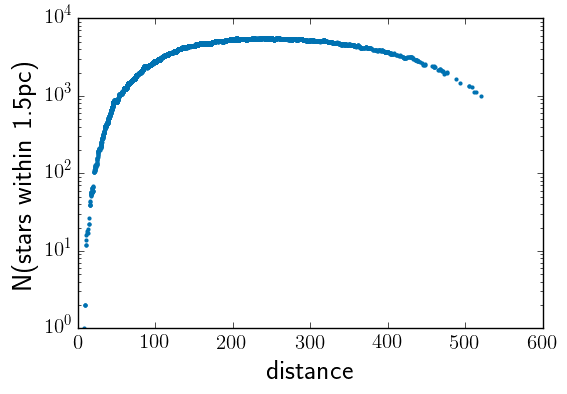

In [321]:
plot(dpairs, dtree.query_radius(atleast_2d(dpairs).T, 1.5, count_only=True), '.')
yscale('log')
xlabel('distance')
ylabel('N(stars within 1.5pc)')

In [322]:
N_per_star = 10
result = dtree.query_radius(atleast_2d(dpairs).T, 1.5,)

In [323]:
ind_control = []
for row in result:
    if len(row)==0:
        continue
    ind_control.append(ind_snr[choice(row, size=N_per_star)])
ind_control = hstack(ind_control)

In [324]:
d[ind_control]

array([ 134.79313333,  134.09308024,  135.34430614, ...,   51.29613653,
         51.67224418,   51.11616624])

(array([  1.27789324e-03,   4.12849385e-03,   6.21210279e-03,
          4.10036412e-03,   1.99136536e-03,   9.88924240e-04,
          3.77559365e-04,   1.73710187e-04,   8.76770660e-05,
          2.88603676e-05]),
 array([   3.49184748,   55.12620241,  106.76055735,  158.39491228,
         210.02926721,  261.66362214,  313.29797707,  364.932332  ,
         416.56668693,  468.20104186,  519.83539679]),
 <a list of 1 Patch objects>)

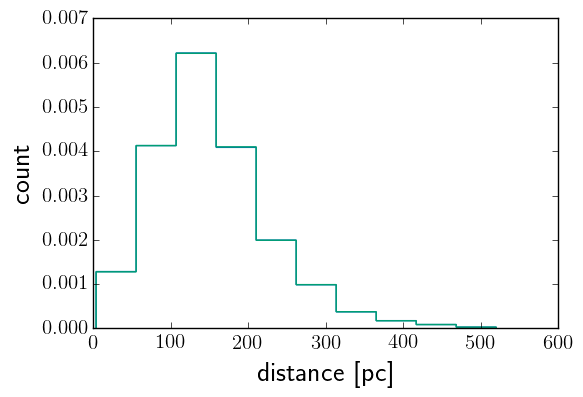

In [325]:
c,bins,patches=hist(dpairs, normed=True, histtype='step')
xlabel('distance [pc]')
ylabel('count')
hist(d[ind_control], bins=bins, normed=True, histtype='step')

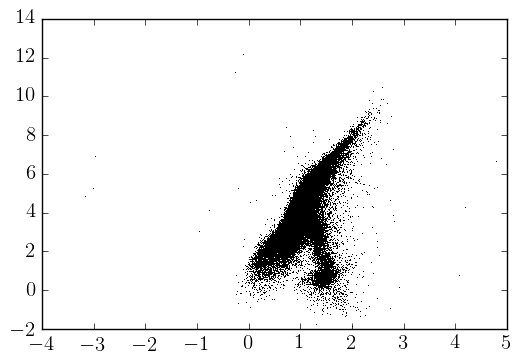

In [326]:
plot(gjcolor[ind_control], gMag[ind_control], 'k,')

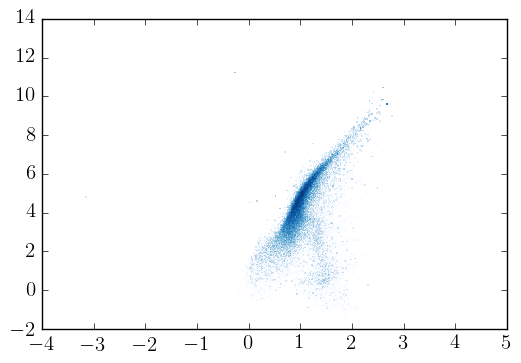

In [328]:
c, ye, xe = histogram2d(gjcolor[ind_control], gMag[ind_control], 512,)
x,y = meshgrid((xe[1:]+xe[:-1])*0.5, (ye[1:]+ye[:-1])*0.5)
pcolormesh(y,x,c, norm=mpl.colors.LogNorm(), cmap='Blues', zorder=-1)


In [329]:
def draw_cmd():
    c, ye, xe = histogram2d(gjcolor[ind_control], gMag[ind_control], 512,)
    x,y = meshgrid((xe[1:]+xe[:-1])*0.5, (ye[1:]+ye[:-1])*0.5)
    pcolormesh(y,x,c, norm=mpl.colors.LogNorm(), cmap='Blues', zorder=-1)


[(8, -1), (8, -1), (8, -1), (8, -1)]

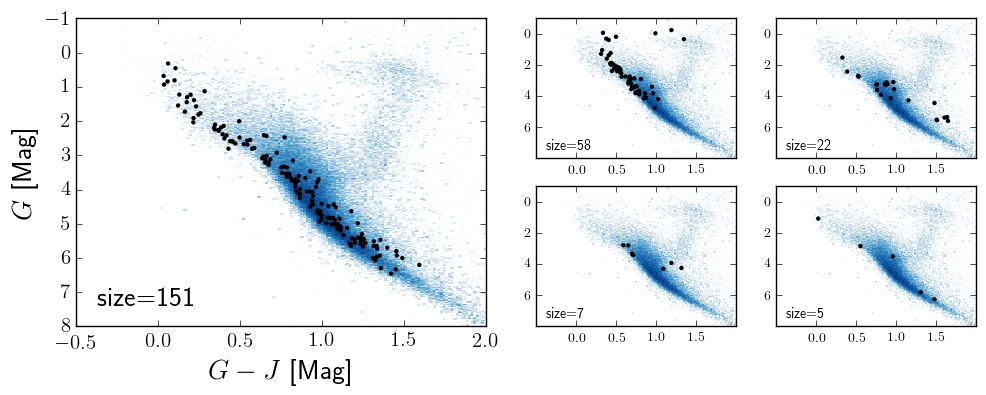

In [330]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec

fig = figure(figsize=(10,4))
fig.subplots_adjust(top=0.95, right=0.98, bottom=0.18, left=0.08)
ax0 = subplot(121)
g = Gc[0]
pos = {node:(gjcolor[node],gMag[node]) for node in g.nodes()}
nx.draw_networkx(g, pos=pos, node_size=10, width=0, with_labels=False, node_color='k')
xlabel(r'$G-J$ [Mag]')
ylabel(r'$G$ [Mag]')
text(0.05, 0.05, 'size=%i' % (len(g)),
     transform=gca().transAxes, va='bottom', ha='left', size=20)
draw_cmd()
ax0.set_xlim(-0.5, 2)
ax0.set_ylim(8,-1)

grid = gridspec.GridSpec(2,2)
grid.update(left=0.54, right=0.98)
ax = [subplot(i,) for i in grid]
for i, gi in enumerate([6,13,37,51]):
    g = Gc[gi]
    sca(ax[i])
    pos = {node:(gjcolor[node],gMag[node]) for node in g.nodes()}
    nx.draw_networkx(g, pos=pos, node_size=10, width=0, with_labels=False, ax=ax[i], node_color='k')
    ax[i].xaxis.set_major_locator(MaxNLocator(nbins=5,prune='both'))
    ax[i].yaxis.set_major_locator(MaxNLocator(nbins=5,prune='both'))
    ax[i].text(0.05, 0.05, 'size=%i' % (len(g)),
               transform=ax[i].transAxes, va='bottom', ha='left')
    ax[i].tick_params(which='both', labelsize=10)
    draw_cmd()

[a.set_xlim(-0.5,2.) for a in ax]
[a.set_ylim(8,-1) for a in ax]
# savefig('../paper/figures/gjg_graphviz_examples.png')


In [ ]:
(mepairs['sep']<1).sum()

4236


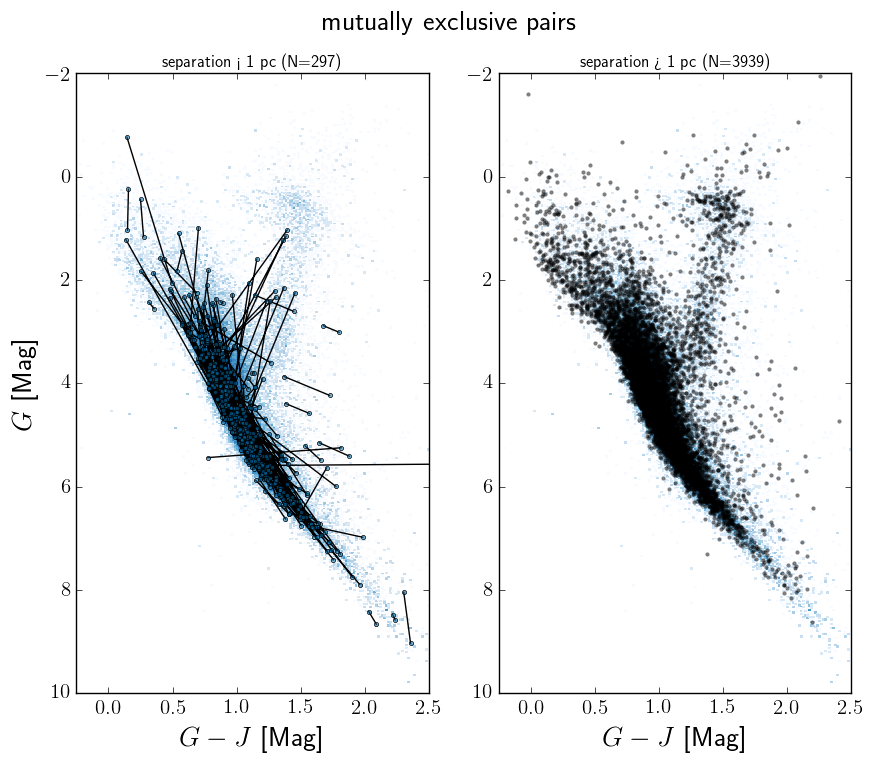

In [331]:
fig, ax = subplots(1,2, figsize=(10,8))

suptitle('mutually exclusive pairs', size=20)

mepairs = cmpairs[(nsize==2)]
print(mepairs.size)

star1,star2 = mepairs['star1'], mepairs['star2']

gj1, gj2 = gjcolor[star1], gjcolor[star2]
g1, g2 = gMag[star1], gMag[star2]

x = vstack([gj1,gj2,[None]*gj1.size]).T
y = vstack([g1,g2,[None]*g1.size]).T

sepdivide = 1  # pc

sca(ax[0])
draw_cmd()
l, = plot(x[mepairs['sep']<sepdivide].ravel(),y[mepairs['sep']<sepdivide].ravel(),
     'ko-', lw=1., mec='k', mew=0.5, ms=3, mfc='#0072B2', )
l.set_markerfacecolor((0, 114/256., 178/256., 0.5))

xlim(-.25,2.5)
ylim(10,-2)

xlabel(r'$G-J$ [Mag]')
ylabel(r'$G$ [Mag]')
title('separation < %.0f pc (N=%i)' % (sepdivide,(mepairs['sep']<sepdivide).sum()))

sca(ax[1])
draw_cmd()
plot(x[mepairs['sep']>sepdivide].ravel(),y[mepairs['sep']>sepdivide].ravel(),
     'k.', alpha=.5)
xlim(-.25,2.5)
ylim(10,-2)
xlabel(r'$G-J$ [Mag]')
title('separation > %.0f pc (N=%i)' % (sepdivide,(mepairs['sep']>sepdivide).sum()))
# savefig('../paper/figures/gjg_mepairs.png')

# Catalog

In [ ]:
from astropy.table import join

In [ ]:
tt = Table()
tt['star1'] = cmpairs['star1']
tt['star2'] = cmpairs['star2']
tt['star1 source id'] = tgas.source_id[cmpairs['star1']]
tt['star2 source id'] = tgas.source_id[cmpairs['star2']]
tt['sep'] = cmpairs['sep']
tt['sep'].format='%9.1f'
tt['lnL1/L2'] = llr[llr>6]
tt['lnL1/L2'].format='%9.1f'
tt['nsize'] = nsize
tt['RAVE_OBS_ID1'] = rave['RAVE_OBS_ID'][cmpairs['star1']]
tt['RAVE_OBS_ID2'] = rave['RAVE_OBS_ID'][cmpairs['star2']]

In [ ]:
nid = []
def get_nid(node):
    out = []
    for i, g in enumerate(Gc):
        if node in g:
            out.append(i)
    if len(out)>1:
        raise ValueError('boo')
    return out[0]
nid = [get_nid(i) for i in tt['star1']]

tt['nid'] = nid

In [ ]:
c1 = tgas.get_coord()[cmpairs['star1']]
c_mwsc = coords.SkyCoord(mwsc['GLON'], mwsc['GLAT'], mwsc['d'], frame=coords.Galactic)
idx_mwsc, sep2d_mwsc, dist3d_mwsc = c1.match_to_catalog_3d(c_mwsc)

tt['star1 closest imwsc'] = idx_mwsc
tt['star1 dclosest mwsc'] = dist3d_mwsc
tt['star1 dclosest mwsc'].format='%9.1f'

In [ ]:
obass.colnames

In [ ]:
t1 = Table([tgas.hip[cmpairs['star1']]], names=['HIP'])
t1_obass = join(obass['OBAss','HIP'], t1, keys='HIP', join_type='right')
t2 = Table([tgas.hip[cmpairs['star2']]], names=['HIP'])
t2_obass = join(obass['OBAss','HIP'], t1, keys='HIP', join_type='right')


In [ ]:
tt['star1 OBAss'] = t1_obass['OBAss']
tt['star2 OBAss'] = t2_obass['OBAss']

## table stub

In [ ]:
stub = tt['star1 source id', 'star2 source id', 'sep', 'lnL1/L2', 'nid', 'nsize'][:10]

In [ ]:
stub['sep'].name = 'separation'
stub['separation'].unit = u.pc
stub['lnL1/L2'].name = '$\ln \mathcal{L}_1 /\mathcal{L}_2$'
stub['nid'].name = 'ID$_\mathrm{network}$'
stub['nsize'].name = '$N_\mathrm{network}$'

In [ ]:
caption = r'Catalog of candidate co-moving pairs \label{tab:catalog}'
tablefoot = r'\tablecomments{Table 1 is published in its entirety in the machine-readable format. A portion is shown here for guidance regarding its form and content.}'

stub.write('../paper/stub.tex', format='ascii.aastex',
           caption=caption, latexdict=dict(tablefoot=tablefoot))

## Pair list for Hans-Walter Rix

In [ ]:
condllr = llr>cutlist[3][1]
condsep = (sep>.5) & (sep<2)
cond = condllr & condsep  & mutexc
print(cond.sum())
print((cond & matched_rave12).sum())

tHRW = Table(pairidx[cond])

tHRW['RAVE_OBS_ID1'] = rave['RAVE_OBS_ID'][pairidx[cond]['star1']]
tHRW['RAVE_OBS_ID2'] = rave['RAVE_OBS_ID'][pairidx[cond]['star2']]
tHRW['RAVE_HRV1'] = rave['HRV'][pairidx[cond]['star1']]
tHRW['RAVE_HRV2'] = rave['HRV'][pairidx[cond]['star2']]
tHRW['RAVE_eHRV1'] = rave['eHRV'][pairidx[cond]['star1']]
tHRW['RAVE_eHRV2'] = rave['eHRV'][pairidx[cond]['star2']]

tHRW['lnH1'] = lnH1[cond]
tHRW['lnH2'] = lnH2[cond]
tHRW['lnH1H2'] = tHRW['lnH1'] - tHRW['lnH2']
tHRW.write('HRW.fits')

In [ ]:
fig, ax = subplots(1,2, figsize=(10,4))
fig.subplots_adjust(wspace=0.3)
ax[0].hist(tHRW['sep'], 8, color='k')
ax[0].set_xlabel('separation [pc]')
ax[0].set_ylabel('count')
ax[1].plot(tHRW['sep'], (tHRW['RAVE_HRV1']-tHRW['RAVE_HRV2'])/hypot(tHRW['RAVE_eHRV1'],tHRW['RAVE_eHRV2']), 'k.')
ax[1].axhline(0, c='k')
ax[1].set_xlabel('separation [pc]')
ax[1].set_ylabel(r'$\Delta HRV / \sigma_{\Delta HRV}$')
tight_layout()
savefig('tHRW_summary.png')

# Pair lists for isochrone

1. All pairs within some radius of the Pleiades
2. 1024 pairs outside of all known clusters / associations (or @smoh 's "mutually exclusive" samples)
3. 1024 random pairs of TGAS stars

In [ ]:
ple = coords.SkyCoord("03 47 00.0 +24 07 00", unit=(u.hourangle, u.deg))

In [ ]:
sep_ple1 = c1.separation(ple)
sep_ple2 = c2.separation(ple)
within = (sep_ple1<5*u.deg) & (sep_ple2<5*u.deg)
print(within.sum())

In [ ]:
cut = cutlist[1][1]
llrcut = llr>cut
print(llrcut.sum())
print((llrcut & within).sum())

fig, ax = subplots(1,2, figsize=(12,5))
sca(ax[0])
plot(l1[llrcut], d1[llrcut], '.')
plot(l1[llrcut & within], d1[llrcut & within], '.')
plot(l2[llrcut & within], d2[llrcut & within], '.')
xlim(150,180)
ylim(100,180)

sca(ax[1])
axvline(56.74)
axhline(24.117)
xlim(45, 70)
ylim(10, 40)
plot(ra1[llrcut], dec1[llrcut], '.')
plot(ra1[llrcut & within], dec1[llrcut & within], '.')
plot(ra2[llrcut & within], dec2[llrcut & within], '.')
from matplotlib import patches
gca().add_artist(Circle((ple.ra.value, ple.dec.value), 5., facecolor='gray', alpha=.3))

# Cross matching to known clusters / OB associations

In [ ]:
mwsc = Table.read('../data/J_A+A_585_A101/catalog.dat', readme='../data/J_A+A_585_A101/ReadMe',
                 format='ascii.cds')
print('total number of mwsc', len(mwsc))
print('number of mwsc d<600 pc', (mwsc['d']<600).sum())

In [ ]:
obass = Table.read('../data/J_AJ_117_354/tablec1.dat', readme='../data/J_AJ_117_354/ReadMe',
                    format='ascii.cds')
print('OB association stars', len(obass))

In [ ]:
from astroquery.simbad import Simbad

In [ ]:
# query simbad on HIP id's to get coordinates
customSimbad = Simbad()
customSimbad.add_votable_fields('sptype', 'parallax')
result = customSimbad.query_objects(['HIP %i' % hip for hip in obass['HIP']])
print( unique([s.decode("utf-8")[0] if len(s)>0 else '?' for s in result['SP_TYPE']]) )

In [ ]:
def get_distance(parallax, parallax_error):
    """
    Return the distance [kpc] point estimate with the Lutz-Kelker correction
    
    parallax : float, in mas
    parallax_error : float, in mas
    """
    snr = parallax / parallax_error
    pnew = parallax * (0.5 + 0.5*np.sqrt(1 - 16./snr**2))
    # if snr<4, the value will be maksed
    return 1./pnew

obass_dist = get_distance(result['PLX_VALUE'], result['PLX_ERROR'])

In [ ]:
obass_c = coords.SkyCoord(result['RA'], result['DEC'], unit=(u.hourangle, u.deg),
                          distance=obass_dist*u.pc)

In [ ]:
obass_cg = obass_c.transform_to(coords.Galactic)

In [ ]:
figure(figsize=(10,6))
# plot(d1[condllr], sep[condllr], '.', color='red', alpha=.5)
plot(d1[llr>6], sep[llr>6], '.', color='red', alpha=.2)
yscale('log')
xlabel('$d_1$ [pc]')
ylabel('separation [pc]')
ylim(0.1, 1.2e2)
xlim(0,600)
grid()

for cc in mwsc['d'][mwsc['d']<600]:
    axvline(cc, c='k', lw=1, ymin=0.2, ymax=0.4)
# savefig('d1_sep_mwsc.png')

In [ ]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)